# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
dataDir = "E:/AV/DataSetExploration/drone-dataset-tools/data/location-2/home"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2/lab"
# dataDir = "/home/office/AV/DataSetExploration/data/ind/location-2/csv"

In [2]:
exec(open('init_notebook.py').read())

current working dirE:\AV\DataSetExploration\TTI-dataset-tools\src


In [3]:
%load_ext autoreload
%autoreload 2

In [24]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme()

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [5]:
from ind_tools.IndTransformer import IndTransformer

In [6]:
sceneId = 30
# date = "2022-12-22"
date = "2022-12-09"
fps=5
minYDisplacement = 5
maxXDisplacement = 9
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))


In [7]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed',
        fps=fps,
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)

indTransformer = IndTransformer(colMapper)

In [8]:
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
pedDf.describe()

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY
count,11005.000000,11005.000000,11005.000000,11005.0,11005.0,11005.000000,11005.000000,11005.000000,11005.000000,11005.000000,11005.000000,11005.000000,11005.000000,11005.000000
mean,23.617356,15063.458882,23882.476056,30.0,6.0,0.965564,-0.024273,0.091518,0.301005,0.014632,0.005900,1.407590,1.037594,2.987692
std,3.326224,9030.593546,3338.661007,0.0,0.0,1.651302,1.802848,0.499796,1.334505,0.266647,0.259011,0.384967,0.930713,1.798325
min,18.000000,15.000000,18004.000000,30.0,6.0,-7.151191,-3.523143,-2.272814,-3.703271,-2.374641,-2.426475,0.072169,0.000000,0.000000
25%,21.000000,6860.000000,21302.000000,30.0,6.0,0.103998,-1.575452,-0.329992,-1.214733,-0.112865,-0.131374,1.206726,0.361038,1.439640
50%,24.000000,15531.000000,24113.000000,30.0,6.0,1.233094,-0.021928,0.210072,1.020302,0.012015,0.003094,1.393220,0.847968,2.983286
75%,26.000000,22401.000000,26335.000000,30.0,6.0,1.976637,1.515586,0.433710,1.376689,0.140052,0.142486,1.561722,1.442990,4.540727
max,29.000000,32086.000000,29594.000000,30.0,6.0,6.920119,3.604267,1.752805,3.731013,1.785514,2.813887,3.861455,9.169883,6.440932


In [9]:
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])

## Preprocessing data

### 1. filter out data with low Y displacement

In [10]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)
# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')

using min Y displacement (5)


### 2. Transform trajectories to local source coordinate system

In [11]:
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)
# cleanPedDf.head()

### 3. Rotate north-south trajectories to south-north trajectories

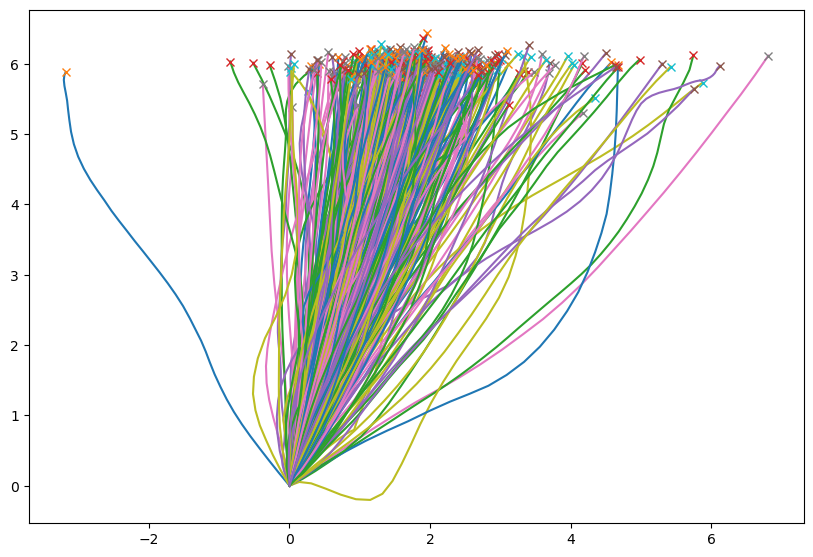

In [12]:
southIds, northDf = indTransformer.convertLocalToNorth(cleanPedDf, tracksMeta)
visualizer.show(northDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

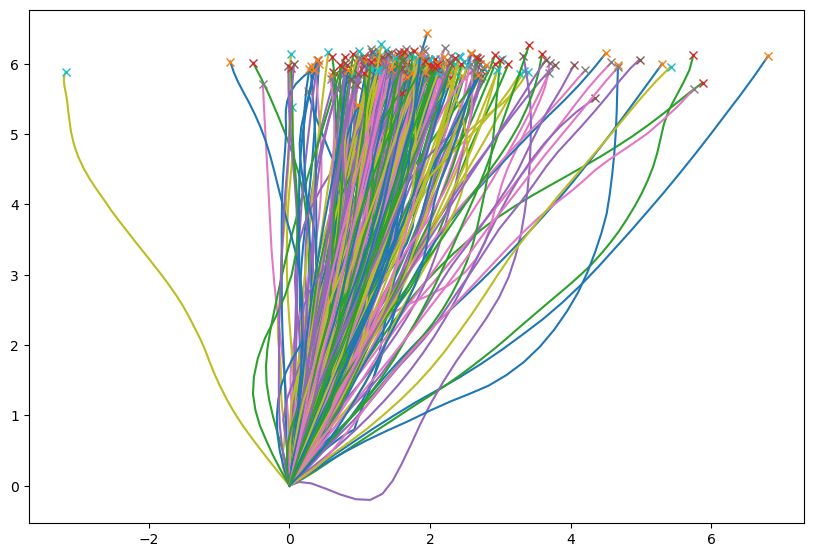

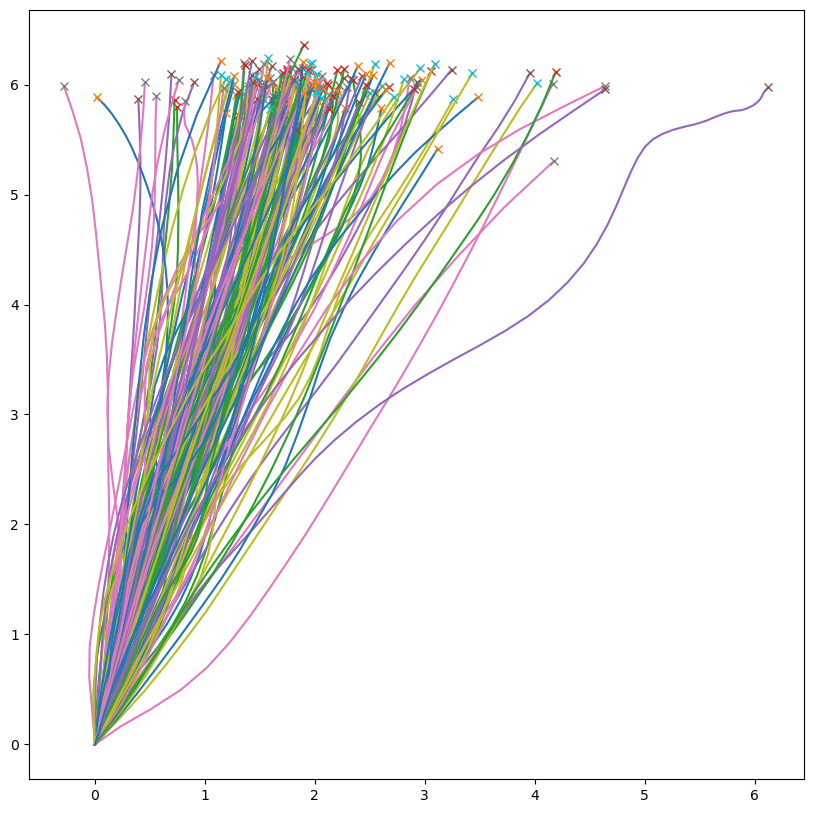

In [13]:
southPeds = northDf[northDf["uniqueTrackId"].isin(southIds)]
visualizer.show(southPeds, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
northPeds = northDf[~northDf["uniqueTrackId"].isin(southIds)]
visualizer.show(northPeds, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

### 4. Shape Analysis from Local Source

### Shape dependencies:
1. spline based clustering
2. language based clustering


#### 5.1 Polygon

In [14]:
from tti_dataset_tools import CrosswalkModel
crosswalkModel = CrosswalkModel(colMapper)

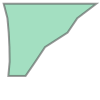

In [43]:
roadWidth = 6.0
interval = 1.0
yTolerance = 0.1

yBreakpoints = list(np.arange(interval, roadWidth, interval))
if (yBreakpoints[-1] - roadWidth) < 0.2:
    yBreakpoints.append(roadWidth)
    
breakpointXVals = crosswalkModel.getAllLocalXAtLocalYBreakpoints(
        tracksDf = northPeds,
        yBreakpoints = yBreakpoints,
        yTolerance = yTolerance
    )
# visualizer.showBreakpointVals(breakpointXVals)
polygon = crosswalkModel.generatePolygonFromBreakpointVals(breakpointXVals)
polygon

## Single Waypoint Analysis
1. We take the mid waypoint and get slope from origin or distance from the y-axis (both represent the same)
2. We take the slope from the waypoint to the goal.
3. These two variables give the the expressive range 
4. Now we can do a heatmap or we can define a scalar measure? The scalar measure can be fitting a spline with two linear components. nope...

In [16]:
# Some trajectories do not end at 6. Extrapolate?

In [22]:
# df.describe()

In [70]:
from tti_dataset_tools import RegularKnotsModel
regKnotsModel = RegularKnotsModel(colMapper)
sns.set(font_scale=3)

In [71]:
# export northPeds to run visualizations on pcg gen project
northPeds.to_csv(f"northPeds-scene-{sceneId}")

(-1.0, 4.0)

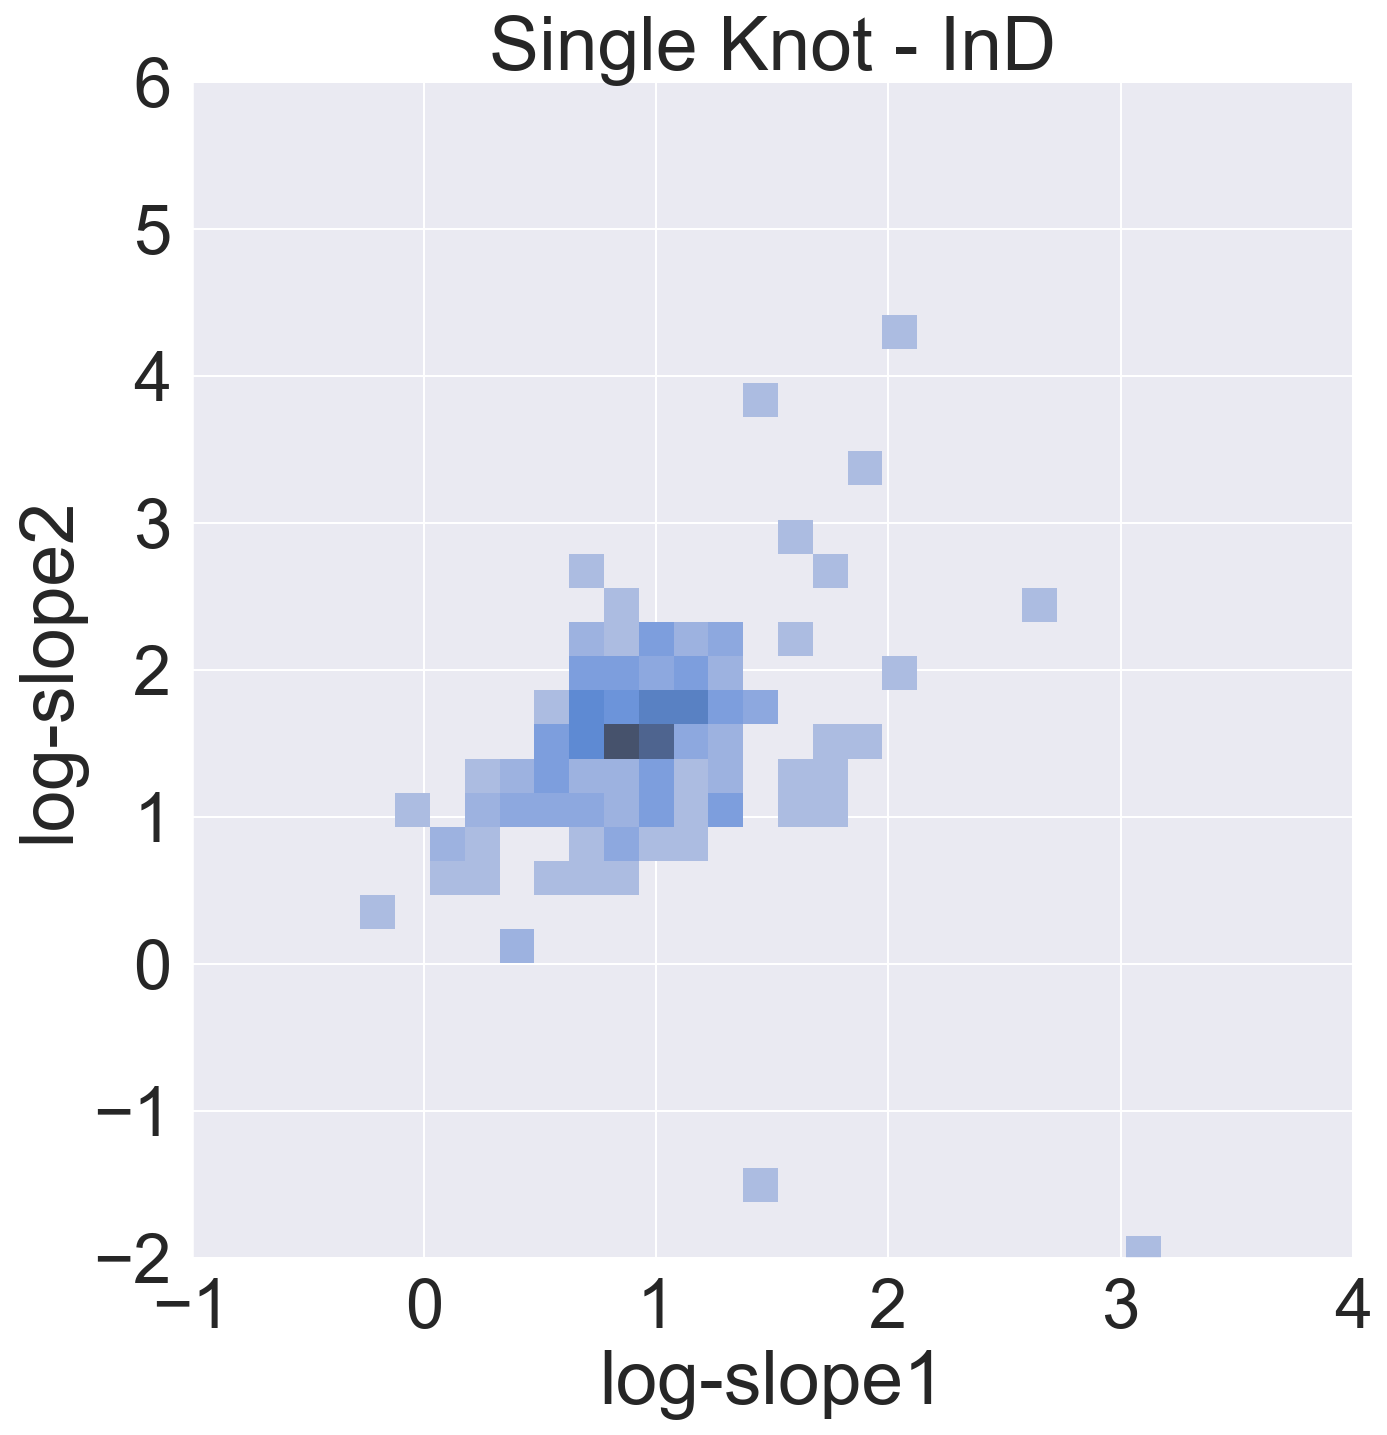

In [69]:
knotDf = regKnotsModel.getSingleKnotData(northPeds, midY=3.0, midYTolerance=1, plot=False)
sns.displot(knotDf, x="log-slope1", y="log-slope2", height=10)
plt.title("Single Knot - InD")
plt.ylim(-2, 6)
plt.xlim(-1, 4)

In [57]:
knotDf2 = regKnotsModel.getKnotData(northPeds, yBreakpoints=[2.0, 4.0], yTolerance=1, plot=False)

Text(0.5, 1.0, 'Double Knot - InD')

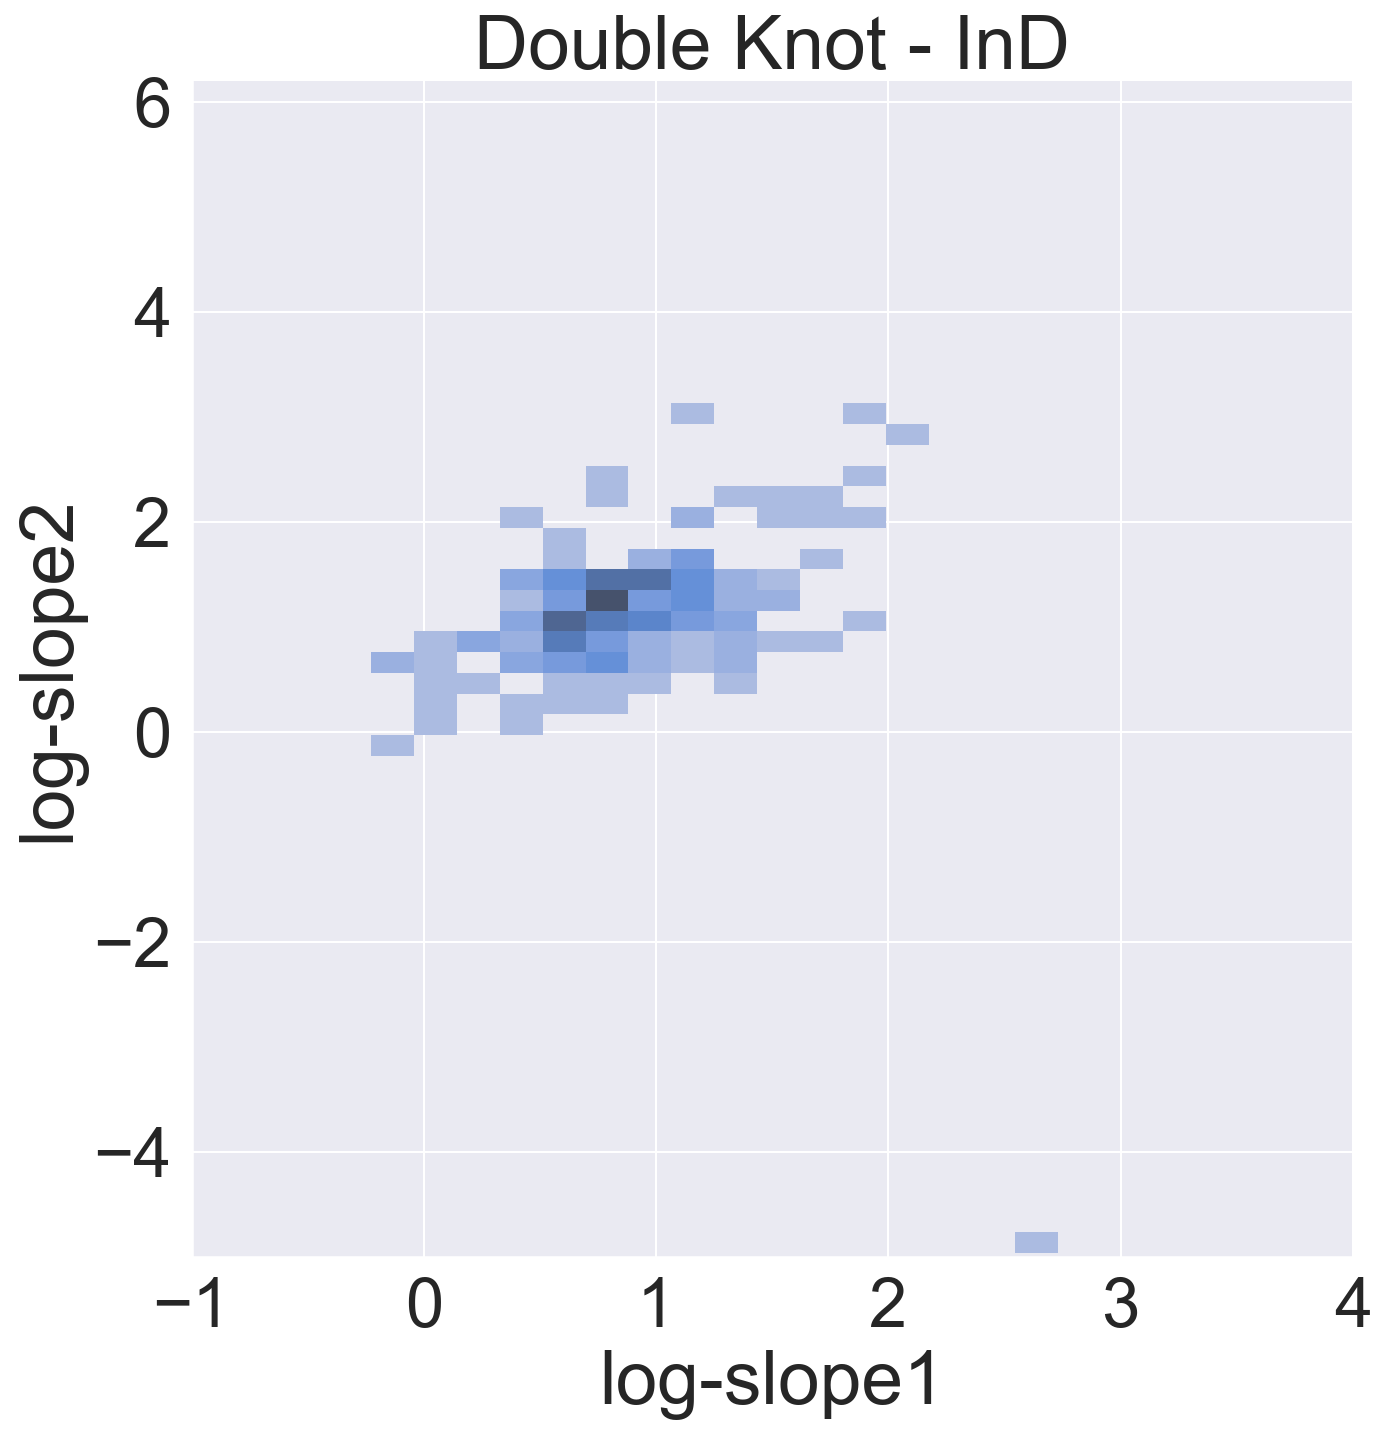

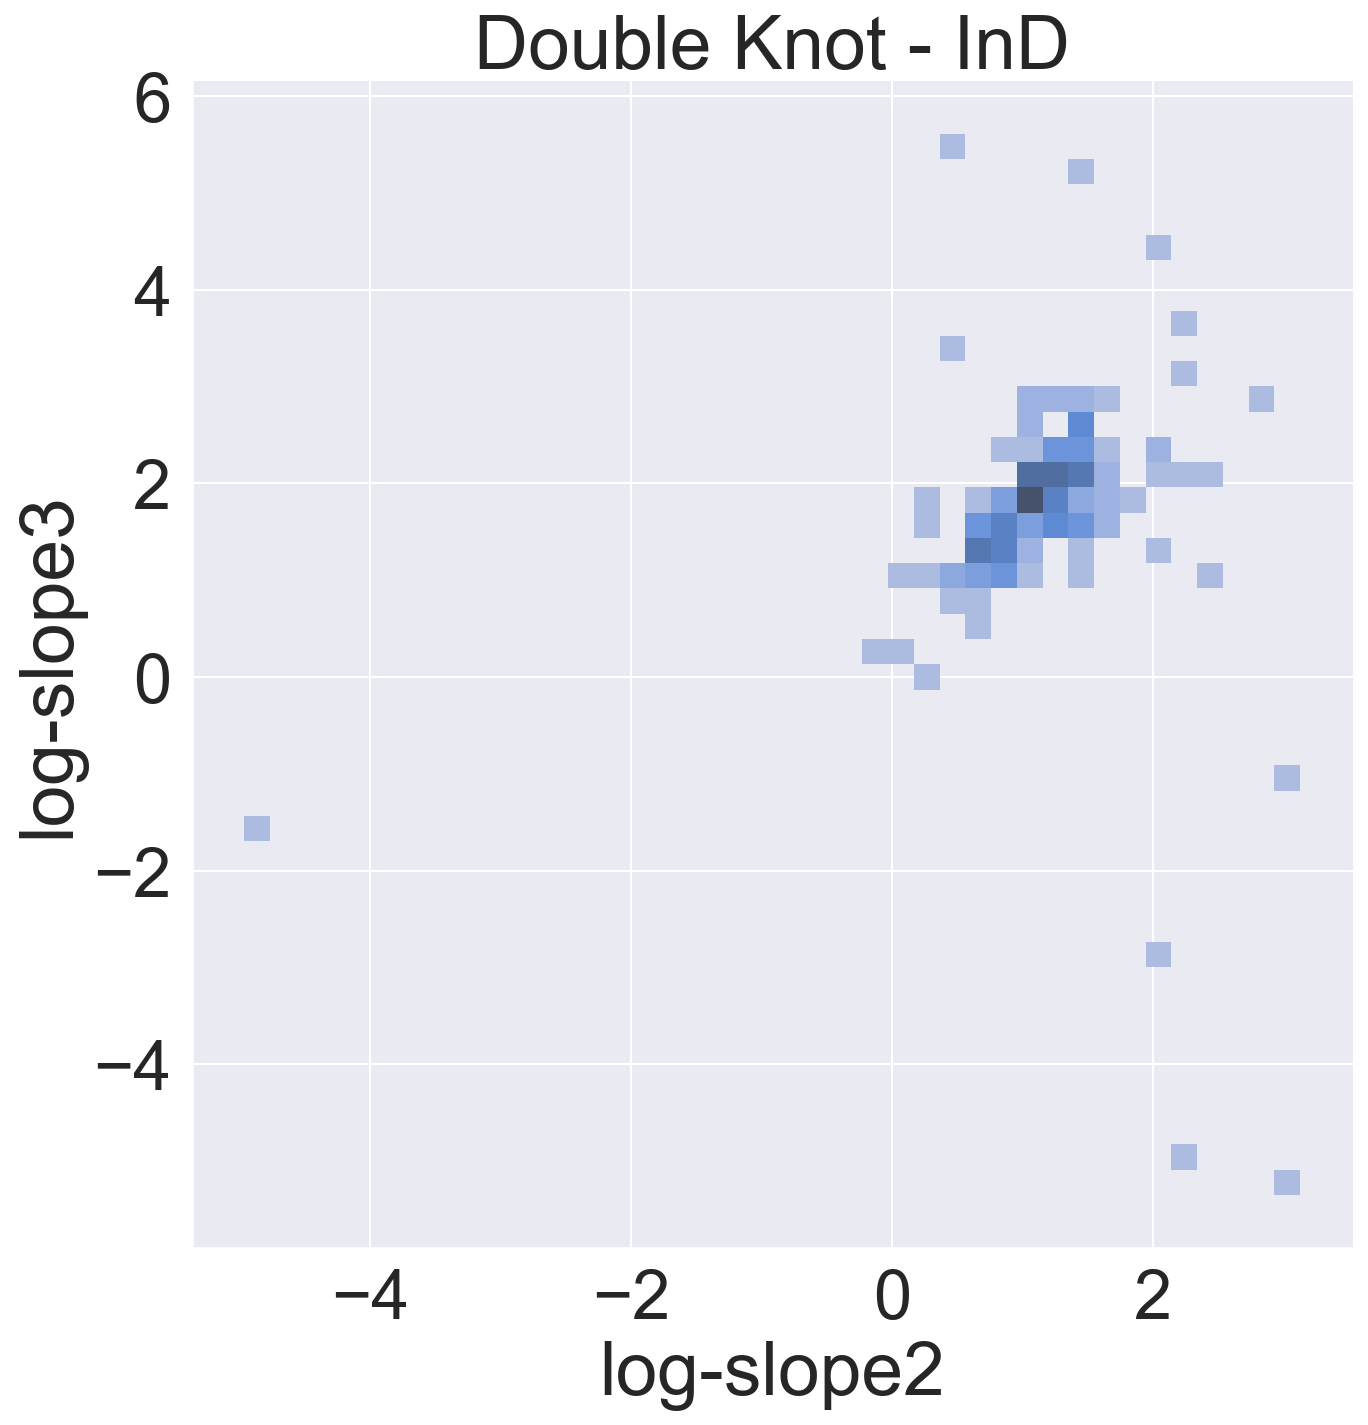

In [68]:
plt.rcParams['figure.dpi'] = 150
sns.displot(knotDf2, x="log-slope1", y="log-slope2", height=10, aspect=1)
plt.title("Double Knot - InD")
plt.ylim(-5, 6.2)
plt.xlim(-1, 4)
sns.displot(knotDf2, x="log-slope2", y="log-slope3", height=10)
plt.title("Double Knot - InD")
# plt.ylim(-0.2, 6.2)
# plt.xlim(-0.2, 6.2)